<span style="font-size:25px">___ATENCIÓN!!___ El presente documento se ha hecho con la intención de mostrar de algna manera el trabajo que ha habido detrás de las decisiones finales tomadas. Sin embargo, el proceso no se ha llevado a cabo en el mismo orden en que se presenta el presete documento. Aunque en este _notebook_ se han llevado a cabo unas pocas iteraciones, la realidad es que se han hecho muchas más, tras las cuales normalmente se ha vuelto a la fase de análisis de datos y a intentar enriquecer los datos para mejorar los modelos.</span>

# Pruebas entrenamientos de modelos

En el presente documento se presentan las diferentes pruebas que se han hecho en para encontrar el modelo que mejores predicciones nos ofrezca a partir de los datos con los que contamos.

In [2]:
## Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Para el cálculo de distancias entre apartamentos y medios de transporte
from geopy.distance import distance
from decimal import *
## Librerías para el entrenamiento del modelo
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

In [34]:
# Importamos data set
df = pd.read_csv('../data/df_pruebas_modelos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12637 entries, 0 to 12636
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    12637 non-null  int64  
 1   neighbourhood_group_cleansed  12637 non-null  object 
 2   bathrooms                     12637 non-null  int64  
 3   bedrooms                      12637 non-null  int64  
 4   price                         12637 non-null  float64
 5   neighbourhood_scale           12637 non-null  float64
 6   neighbourhood_num             12637 non-null  int64  
 7   terraza                       12637 non-null  int64  
 8   balcon                        12637 non-null  int64  
 9   calefaccion                   12637 non-null  int64  
 10  pool                          12637 non-null  int64  
 11  garaje                        12637 non-null  int64  
 12  aire_acondicionado            12637 non-null  int64  
 13  a

In [35]:
target = "price"
y,X =df[target], df.drop(target,axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

Normalizamos el DS utilizando _StandardScaler_ y convertimos las variables no-numérica en variables numéricas con _OneHotEncoder_.

In [ ]:
numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

### Elección del modelo

Comprobamos diferentes modelos de regresión para ver cuáles son los más idóneos.

In [37]:
models = {"lr":LinearRegression(),
          "ridge":Ridge(alpha=0),
          "lasso":Lasso(),
          "SGD":SGDRegressor(),
          "HuberRegressor":HuberRegressor(),
          "Elastic":ElasticNet(),
          "XGBRegressor":XGBRegressor(),
          "SVR":SVR()}

def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
        df_metrics_analysis = pd.DataFrame(metrics_analysis).sort_values('mape')
    return df_metrics_analysis

In [38]:
get_results(X_train, y_train, X_test, y_test)

 38%|███▊      | 3/8 [00:00<00:00,  7.50it/s]c:\Users\marco\anaconda3\envs\entorno_tfm\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


,r2,mse,rmse,mape
SVR,0.394427,1315.957409,36.276127,0.242097
HuberRegressor,0.413213,1275.133593,35.709013,0.242677
XGBRegressor,0.420912,1258.403869,35.473989,0.250853
ridge,0.414320,1272.728792,35.675325,0.255776
lr,0.414745,1271.805403,35.662381,0.255940
SGD,0.404258,1294.594641,35.980476,0.258835
lasso,0.390217,1325.105703,36.402001,0.268854
Elastic,0.374379,1359.523097,36.871711,0.276899


In [39]:
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [ ]:
model = SVR(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [ ]:
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4403799552629647 mse: 1280.1175688196925 rmse: 35.77873067647443 mape: 0.22404595230115423


In [ ]:
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4652383396121613 mse: 1199.0981530177405 rmse: 34.62799666480492 mape: 0.2277298489683464


In [ ]:
test_predict_analysis["y_pred_diff"]=test_predict_analysis["y_pred"]-test_predict_analysis["y"]

Text(0, 0.5, 'Diferencia entre precio predicho y precio real')

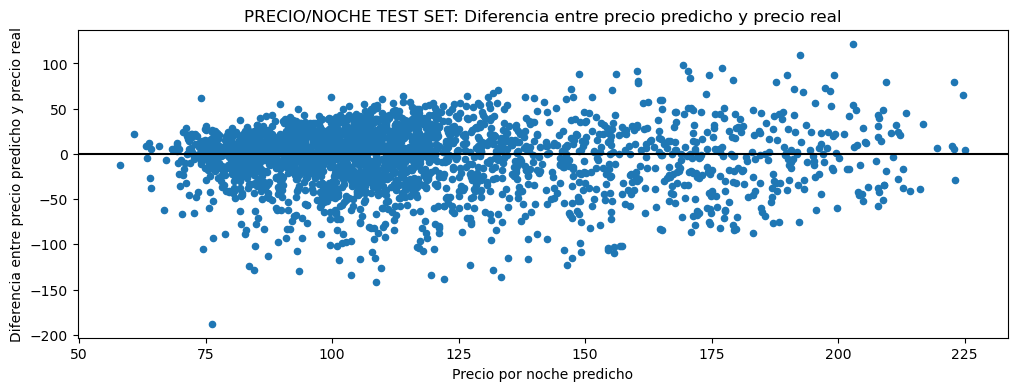

In [ ]:
_,ax = plt.subplots(figsize=(12,4))
test_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")
ax.set_title('PRECIO/NOCHE TEST SET: Diferencia entre precio predicho y precio real')
ax.set_xlabel("Precio por noche predicho")
ax.set_ylabel("Diferencia entre precio predicho y precio real")